# Credit Card Fraud Dataset
## About The Dataset
This dataset is very popular for all kinds of machine learning cyber security techniques. This dataset contains simulated credit card transactions with legitimate and fraudulent transactions. It covers credit cards of over 1000 customers transactions with a pool of 800 merchants.

## Key Details:
Number of Instances: The dataset consists of 1.3 million instances.
Number of Features: There are 23 different features that help describe the inidividual transactions making them all unique.
Target Variable: The target variable in the dataset is is_fraud, representing the if the transaction actually was fraudulent.

### Data Types:
The features include both numerical and categorical variables.
They cover a wide range of aspects such as transaction time, credit card number, zip code of the transaction, merchant details and more.

### Applications:
The Credit Card Fraud Dataset is widely used in the machine learning community for:
- Cyber Security

## Kmeans Clustering: Predicting likelyhood that a transaction is Fraudulent
Feature Engineering: Developing and testing new techniques to handle numerical and categorical data.
Predictive Analytics: Analyzing previous transactions and predicting if a transaction is fraudulent.

# STEP 1
Importing all necessary libraries and setup

In [3]:
# Standard Libraries
import os
import time
import logging

# Install the mxnet library required for certain functionalities in SageMaker
!pip install mxnet==1.7.0.post2 numpy

import numpy as np
np.bool = np.bool_
import mxnet as mx

# AWS SageMaker and Boto3
import sagemaker
from sagemaker import get_execution_role, KMeans
from sagemaker.image_uris import retrieve
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
import boto3
from botocore.exceptions import ClientError

# Data Manipulation
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Additional Libraries
import tarfile
import datetime
import json
import time
from tabulate import tabulate
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score

# Logger Setup
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# File Path and Original Target Column
file_path = "fraudTrain.csv"
original_target_col = "is_fraud"

print("Imported Successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 MB 78.7 MB/s eta 0:00:00:00:0100:01


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[03/27/25 17:09:32] INFO     Found credentials from IAM Role:                                   ]8;id=768918;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=758495;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


[03/27/25 17:09:44] WARNING  Matplotlib is building the font cache; this may take a moment.    ]8;id=378917;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=29526;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/matplotlib/font_manager.py#1095\1095]8;;\

[03/27/25 17:09:47] INFO     generated new fontManager                                         ]8;id=342842;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=482532;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/matplotlib/font_manager.py#1639\1639]8;;\

Imported Successfully!


# STEP 2
Load the data and preview the value counts. Our group decided to take 75% of all fraudulent occurences and plot them and use a 2 to 1 ratio for non fruadulent cases. In theory this could be increased to a larger ratio, and would be interesting to consider for future application and development.

In [4]:
# Load the full dataset
data = pd.read_csv('fraudTrain.csv')

# Separate fraud and non‑fraud cases
fraud_data = data[data['is_fraud'] == 1]
nonfraud_data = data[data['is_fraud'] == 0]

# Sample 75% of all fraud cases
n_fraud_total = len(fraud_data)
n_fraud_sample = int(n_fraud_total * 0.75)
fraud_sample = fraud_data.sample(n=n_fraud_sample, random_state=42)

# Sample non‑fraud at a 4:1 ratio to the fraud sample
n_nonfraud_sample = n_fraud_sample * 2
nonfraud_sample = nonfraud_data.sample(n=n_nonfraud_sample, random_state=42)

# Combine and shuffle
DF = pd.concat([fraud_sample, nonfraud_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

# For compatibility if other code expects `df`
df = DF

# Verify class counts
print(df['is_fraud'].value_counts())

is_fraud
0    11258
1     5629
Name: count, dtype: int64


# STEP 3: Check / Drop Columns

### 3A

In general it is very important to make sure that you data does not have a column with mass amounts of missing data. This will cause massive issues in your dataset if you were to do a data anlysis on the data there would be a massive imbalance causing lots of errors and would also make it impossible to do any type of machine learning on the dataset. 

We chose 15% for my specific dataset because of the high need for security, this ensures that  no column can cause any future errors when running a machine learning model and on top of that also you cannot replace that data with simulated values for almost every situation

In [5]:
def drop_high_missing_columns(dataframe, threshold=0.15):
    """
    Drop columns from the DataFrame where the fraction of missing values exceeds the specified threshold.

    This function calculates the percentage of missing values in each column and removes
    those columns where the fraction of missing values is greater than the threshold. 
    This helps reduce noise and potential bias when features with too many missing values
    might negatively impact the model's performance.

    Parameters:
        dataframe (pd.DataFrame): The input DataFrame to process.
        threshold (float): The maximum allowable fraction of missing values for a column.
                           Columns exceeding this threshold will be dropped (default is 0.3).

    Returns:
        pd.DataFrame: A DataFrame with columns removed that have more than the allowed missing values.
    """
    # Identify columns where the proportion of missing values exceeds the threshold.
    cols_to_drop = dataframe.columns[dataframe.isnull().mean() > threshold]
    
    # Print out the columns that will be dropped for transparency.
    print(f"Dropping columns with more than {threshold*100:.0f}% missing values: {list(cols_to_drop)}")
    
    # Return a new DataFrame with the identified columns removed.
    return dataframe.drop(columns=cols_to_drop)


# Apply the function to the DataFrame to remove columns with too many missing values.
df = drop_high_missing_columns(df)

Dropping columns with more than 15% missing values: []


### 3B

Now that we have dropped all columns with missing data I will now drop the columns that we don't belive are necessary including:
- Birthday - irrelevant to determe whether a transaction is fraudulent
- Unnamed - this was the id of the transaction and has no relevance for the machine learning model
- First/Last name - people may have identical names and it could create a bias flagging all people with the same name as fraudulent transactions if there was fraud under their name
- City Pop / Street / Lat / Long - All of these refer to the location of the individual's home which should not have any impact on whether a transaction is fraudulent
- Merch Long / Merch Long -  All of these refer to the exact location of the merchant which should not have an impact of identifying fraudulent transactions
- Unix Time - Conisdering we already have a column taking time into account it would be unneccessary to have a repeat column

In [6]:
def drop_columns(dataframe):
    """
    Drop columns that I have deemed to be irrelavnt.
    """
    cols_to_drop = ["dob", "Unnamed: 0", "first", "last", "gender",
                    "street", "city", "lat", "long", "city_pop", "merch_lat", "merch_long", "unix_time", "state", "job"]
    for i in cols_to_drop:
        dataframe.drop(columns=i, inplace=True)
    return dataframe

df = drop_columns(df)

print('Columns Dropped Successfully!')

Columns Dropped Successfully!


# STEP 4: Remove Rows Missing the Target Variable

### 4A
We dropped all columns within this dataset that had missing target values, this is important because if the target value is missing we are unable to fill in the fill result with precision which could negatively affect the accuracy of the model if you were to train it off of the dataset.

In [7]:
def drop_missing_target(dataframe, target_column):
    """
    Drop rows from the DataFrame where the target variable is missing.

    This function checks if the target column exists in the DataFrame.
    If it does, rows with missing values in the target column are removed.
    This is crucial because missing target values can cause issues during model training,
    leading to inaccurate or biased predictions.

    Parameters:
        dataframe (pd.DataFrame): The input DataFrame to process.
        target_column (str): The name of the target variable column.

    Returns:
        pd.DataFrame: A DataFrame with rows removed where the target variable is missing.
    """
    # Check if the target column exists in the DataFrame.
    if target_column not in dataframe.columns:
        print(f"Target column '{target_column}' not found.")
        return dataframe

    # Record the number of rows before dropping missing target values.
    before = len(dataframe)
    
    # Drop rows where the target column has missing values.
    dataframe = dataframe.dropna(subset=[target_column])
    
    # Record the number of rows after the operation.
    after = len(dataframe)
    
    # Inform the user about how many rows were dropped.
    print(f"Dropped {before - after} rows with missing '{target_column}'.")
    
    return dataframe

# Apply the function to drop rows with missing values in the target column.
df = drop_missing_target(df, original_target_col)

Dropped 0 rows with missing 'is_fraud'.


### 4B
We dropped all rows within this dataset that had missing values, this is important because if there are any missing values in a row and we can't fill it in without the exact information that could completely change the actual information about the transaction which could decrease the accuracy of the model and cost the KCU money

In [8]:
# Drop all rows with missing values from the dataset
df.dropna()

,trans_date_trans_time,cc_num,merchant,category,amt,zip,trans_num,is_fraud
0,2019-06-13 23:33:06,373905417449658,fraud_Carroll PLC,health_fitness,31.84,76665,0a79813e126c5bc7d0e563d612cd1146,0
1,2020-03-13 16:31:11,4070511711385545,fraud_Waters-Cruickshank,health_fitness,81.69,78113,15ee0276674e7bd8b10938516800d79f,0
2,2019-08-03 10:45:45,30343344410970,fraud_Effertz LLC,entertainment,8.49,16239,f44557b47ef1b49ebf662d2241106b7b,0
3,2019-11-23 23:13:29,347612609554823,fraud_Klocko LLC,misc_net,719.57,4953,8a3edc1753e129b6fb0e38d4f3bec697,1
4,2019-11-14 22:43:05,4348786085525522,fraud_Dooley-Thompson,misc_net,712.14,54418,4fd0d8622c00fccf1100bbd73adae401,1
...,...,...,...,...,...,...,...,...
16882,2019-09-17 05:26:46,3533742182628021,fraud_Kiehn-Emmerich,grocery_pos,81.65,29455,c421e7e2858dd0bb125aa5a522f21b57,0
16883,2020-04-28 19:43:50,676173792455,fraud_Deckow-Dare,food_dining,55.90,90403,f1d65777a52ee0944446d5754dbe7620,0
16884,2020-01-11 01:40:48,3529788038921264,fraud_Deckow-O'Conner,grocery_pos,265.09,70065,4d4aceda4795962f4a55259de83bc8e9,1
16885,2019-01-09 22:58:24,4806443445305,fraud_Boyer-Haley,travel,9.91,45638,f766eae4ee862d058458d0a262dc5350,1


# STEP 5: Fill Remaining Missing Values

In general it is very important to fill in remianing values to make sure that the data available in consistend and that it is not missing any data. In this specific case we dediced that it was best to to not fill any values that are missing, this is because in every transaction, each case is completely unique and not dependant on any other transaction. Therefore it would be unfair and harmful to a machine learning model to fill in the information rather than just drop that case especially when you have so much data

In [9]:
def fill_missing_values(dataframe):
    """
    Fill missing values in the DataFrame for both numerical and categorical columns.

    For numerical columns, missing values are replaced with the median. The median is 
    chosen because it is less sensitive to outliers compared to the mean. For categorical 
    columns, missing values are replaced with the string "Missing" to explicitly denote 
    that data was absent.

    Parameters:
        dataframe (pd.DataFrame): The input DataFrame with missing values.

    Returns:
        pd.DataFrame: A new DataFrame with missing values filled in.
    """
    # Create a copy of the DataFrame to avoid modifying the original data.
    df_copy = dataframe.copy()

    # Identify numerical columns using pandas' select_dtypes method.
    numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
    
    # Identify categorical columns (non-numeric) using select_dtypes.
    categorical_cols = df_copy.select_dtypes(exclude=[np.number]).columns

    # Fill missing values in numerical columns with the median value of each column.
    df_copy[numeric_cols] = df_copy[numeric_cols].fillna(df_copy[numeric_cols].median())
    
    # Fill missing values in categorical columns with the string 'Missing'.
    df_copy[categorical_cols] = df_copy[categorical_cols].fillna("Missing")
    
    return df_copy


# Apply the fill_missing_values function to the DataFrame.
df = fill_missing_values(df)

df_untouched = df

# STEP 6: Remove and Handle Outliers

In general it is very important to examine, highlight and remove outliers or find a way to normalize it. As without this, it could create a skew in the model possibly leading it to possibly having a tendency to provide a result more often then others based on the same input

Although in our case, we are specifically lookings for those outliers, it is crucial to keep all transactions as any of them could indicate fraud.

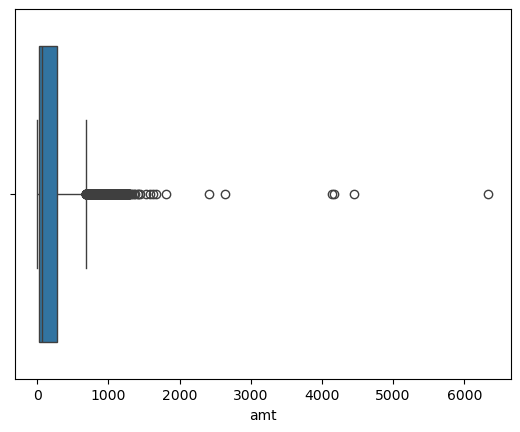

In [10]:
# def remove_outliers(dataframe, col_name, upper_limit):
#     """
#     Remove rows from the DataFrame where the values in the specified column exceed the upper_limit.

#     Outlier removal is crucial to reduce the impact of extreme values that might skew model training.
#     This function filters the DataFrame, keeping only those rows where the value in the given column
#     is below the provided upper_limit. If the specified column is not found, it prints a message and returns
#     the DataFrame unmodified.

#     Parameters:
#         dataframe (pd.DataFrame): The input DataFrame.
#         col_name (str): The name of the column to inspect for outliers.
#         upper_limit (float or int): The threshold value; rows with values equal to or above this will be removed.

#     Returns:
#         pd.DataFrame: The filtered DataFrame with outliers removed.
#     """
#     # Check if the specified column exists in the DataFrame.
#     if col_name not in dataframe.columns:
#         print(f"Column '{col_name}' not found. Skipping outlier removal.")
#         return dataframe

#     # Record the number of rows before removing outliers.
#     before = len(dataframe)
    
#     # Filter the DataFrame to keep rows where the column value is less than the upper limit.
#     dataframe = dataframe[dataframe[col_name] < upper_limit]
    
#     # Record the number of rows after filtering.
#     after = len(dataframe)
    
#     # Inform the user how many rows were removed.
#     print(f"Removed {before - after} outliers from '{col_name}'.")
    
#     return dataframe

# # Apply the outlier removal function to the DataFrame.
# df = remove_outliers(df, col_name="amt", upper_limit=15000)

# If I used the code above it would severly alter the boxplot below
# ____________________________________

sns.boxplot(x=df['amt'])
plt.show()

### Boxplot Interpretation

Based on the boxplot above it is evident that most of all of the transactions go up to around $6,000. Along with that it is important to mention that a majority of the transactions that we are looking at are between $1000 and $2000. 

# STEP 7: Encode Variables
Once the data has only the columns you want with all values filled out use frequency encoding and one hot encoding to change all textual variables to values that the machine learning model can understand (values).

In order for a binary classification model to work all of the columns within the dataset must be numerical. Considering that there are multiple textual columns within the dataset, to make sure that the machine learning model is able to run we need to convert them to numerical values. 

We chose to use frequency encoding for my dataset as there are tons of different values and this technique is most commonly used when there are a large number of individual value frequencies within the dataset.

In [11]:
def encode_categorical_features(dataframe, freq_threshold=10):
    """
    Encode categorical features in the DataFrame using two strategies:
    
    - One-hot encoding for categorical variables with a number of unique categories
      less than or equal to freq_threshold. One-hot encoding creates binary columns for each
      category (dropping the first to avoid multicollinearity).
    
    - Frequency encoding for categorical variables with more than freq_threshold unique categories.
      Frequency encoding replaces each category with its relative frequency in the column.
    
    This approach helps manage high-cardinality features while still providing useful representations
    for variables with fewer categories.
    """
    cat_cols = dataframe.select_dtypes(include=["object"]).columns
    freq_frames = {}

    for col in cat_cols:
        # Frequency encoding
        freq_map = dataframe[col].value_counts(normalize=True)
        freq_frames[col + "_freq"] = dataframe[col].map(freq_map)

    # Combine frequency-encoded columns
    if freq_frames:
        freq_df = pd.DataFrame(freq_frames, index=dataframe.index)
        dataframe = pd.concat([dataframe, freq_df], axis=1)

    # Drop original categorical columns
    dataframe.drop(columns=cat_cols, inplace=True)
    return dataframe

df = encode_categorical_features(df, freq_threshold=10)
df_encoded = df

print("values encoded!")

values encoded!


# PCA
Before running K‑means you standardize all numeric columns so each feature has the same scale (so big numbers don’t overpower small ones), then use PCA to boil hundreds of features down to just two summary columns that capture most of the data. This both speeds up K‑means and makes its distance‑based clusters more meaningful. Plus it lets you plot the results in a simple 2D scatterplot.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.select_dtypes(include=['number']))  # Only numeric columns

# Apply PCA with 3 components
pca = PCA(n_components=2)  # Change to 3 components
principal_components = pca.fit_transform(scaled_features)

# Convert to DataFrame
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df_pca['is_fraud'] = df['is_fraud'].values  # Add the fraud label back

print(df_pca.head())  # Verify the first few rows


        PC1       PC2  is_fraud
0 -1.772140  0.220725         0
1 -1.295668 -0.059051         0
2 -1.142611 -0.157293         0
3  0.636943  2.289274         1
4  0.713770  2.021315         1


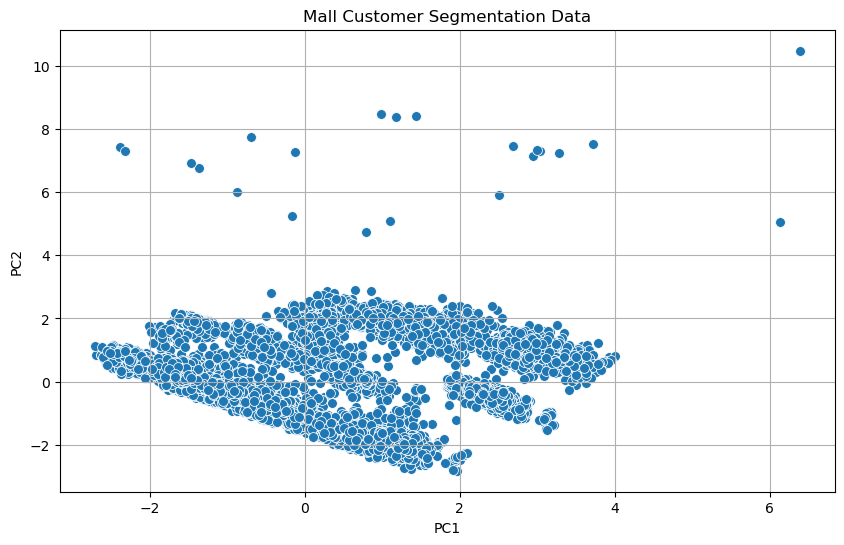

In [ ]:
# Set the size of the plot
plt.figure(figsize=(10, 6))

# Create scatter plot using Seaborn
sns.scatterplot(x='PC1', y='PC2', data=df_pca, s=50)

# Setting the title and labels of the plot
plt.title('Mall Customer Segmentation Data')

# Enabling grid for better readability
plt.grid(True)

# Display the plot
plt.show()

This scatterplot squashes lots of customer information (age, income, spending habits, etc.) down into two simple “summary scores” (PC1 on the horizontal axis and PC2 on the vertical). Each dot is one mall customer. Dots that end up close together represent people with very similar shopping profiles; dots far apart behave very differently. The dense cloud in the middle shows the bulk of customers who share average traits, while the few points floating away are outliers (people whose behavior is unusually high or low compared to the rest). In plain terms, the plot helps you visually spot natural groups of shoppers without getting bogged down in dozens of raw numbers.

# Initialize Sagemaker Session

In [14]:
# Initialize a SageMaker Session
# A SageMaker Session helps in managing the interactions with the AWS SageMaker service, such as creating and training models, and deploying endpoints.
sagemaker_session = sagemaker.Session()

# Retrieve the IAM role
# The IAM role is required by SageMaker to access AWS resources (e.g., S3 buckets) on your behalf.
role = get_execution_role()

# Identify the AWS Region of the SageMaker Session
# This information is used to ensure that resources are created in the same region as the SageMaker session.
region = sagemaker_session.boto_region_name

# Create Boto3 Clients for S3 and SageMaker
# These clients enable programmatic access to S3 and SageMaker services for operations like uploading data and creating training jobs.
s3_client = boto3.client('s3')
sagemaker_client = boto3.client('sagemaker')

# Retrieve the Docker image URI for the KMeans algorithm
# This URI is specific to the AWS region and is used to pull the appropriate image for training.
image_uri = retrieve('kmeans', region)

# Define the Default S3 Bucket for SageMaker
# SageMaker requires an S3 bucket to store training data, models, and outputs. Here, we use the session's default bucket.
bucket = sagemaker_session.default_bucket()

# Set the S3 Prefix for Storing Data
# The prefix is used to organize the data in the bucket, making it easier to manage and locate.
prefix = 'sagemaker/mall/kmeans-all'

# Output the IAM Role ARN and AWS Region for verification
print("Execution Role ARN:", role)
print("AWS Region:", region)

[03/27/25 14:45:23] INFO     Found credentials from IAM Role:                                   ]8;id=426634;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=815454;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Found credentials from IAM Role:                                   ]8;id=119885;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=19340;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

[03/27/25 14:45:24] INFO     Found credentials from IAM Role:                                   ]8;id=740115;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=829780;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=4315;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=101270;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=859554;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=179906;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

Execution Role ARN: arn:aws:iam::781711204486:role/LabRole
AWS Region: us-east-1


# Clustering

This block of code is simply training several K‑means clustering models — each with a different number of clusters (from 2 up to 7) — so you can compare which grouping makes the most sense for your two‑dimensional data (PC1 and PC2). For each value of k, it creates a unique SageMaker training job, runs them all in parallel, and saves the resulting model files into your S3 bucket. Once every job finishes, it collects and prints the exact S3 locations where each trained model was stored so you can easily find and evaluate them later.

In [15]:
# Define the range of k values for the KMeans clustering
# This range will determine how many models we train, each with a different number of clusters.
k_values = range(2, 8)

print(df_pca.columns)
# fraud_labels = df_pca['is_fraud'].to_numpy()
df_pca = df_pca[['PC1', 'PC2']].astype('float32')

# Initialize lists to keep track of the S3 paths for the trained models and their training job names.
model_paths = []
training_jobs = []

# Set the output path in the S3 bucket for the trained models
# This path will be used to store the output (model artifacts) of each training job.
output_path = f's3://{sagemaker_session.default_bucket()}/sagemaker/mall/kmeans-one-b/output'

# Iterate over each k value to train a separate KMeans model for that number of clusters
for k in k_values:
    # Generate a unique job name for each training job based on the k value
    job_name = f'kmeans-mall-one-b-k-{k}'
    
    # Initialize the KMeans estimator from SageMaker with the specific k value
    # Configuration includes instance type, number of instances, and the specified k value.
    kmeans = KMeans(
        sagemaker_session=sagemaker_session,
        role=role,
        instance_count=1,
        instance_type='ml.m5.large',
        k=k,
        output_path=output_path,
        job_name=job_name,
        feature_dim=2  # Specify the number of features in the input data
    )
    
    # Start the training job for the KMeans model
    # We use 'wait=False' to start each training job asynchronously.
    kmeans.fit(kmeans.record_set(df_pca.values), wait=False)
    training_jobs.append((k, kmeans.latest_training_job.name))

# After initiating all training jobs, we wait for each to complete and collect their model URIs
for k, job_name in training_jobs:
    # Wait for the completion of the training job
    sagemaker_client.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
    
    # Retrieve the S3 URI of the model artifacts for the completed training job
    training_job_description = sagemaker_client.describe_training_job(TrainingJobName=job_name)
    model_s3_uri = training_job_description['ModelArtifacts']['S3ModelArtifacts']
    model_paths.append((k, model_s3_uri))

# Print the S3 paths of the model artifacts for all trained models
# This provides a clear reference to the location of each model for further analysis or deployment.
headers = ['k Value', 'S3 Model Artifact Path']
print(tabulate(model_paths, headers=headers))

Index(['PC1', 'PC2', 'is_fraud'], dtype='object')


[03/27/25 14:45:32] INFO     Same images used for training and inference. Defaulting to image     ]8;id=609293;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=202071;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=992201;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=623361;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=966286;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=871178;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=879562;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=222972;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-27-14-45-32-467        ]8;id=962288;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=67617;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

[03/27/25 14:45:33] INFO     Same images used for training and inference. Defaulting to image     ]8;id=881954;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=562643;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=301580;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=983386;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=680220;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=579053;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=113892;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=957665;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-27-14-45-33-507        ]8;id=691488;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=248271;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

[03/27/25 14:45:35] INFO     Same images used for training and inference. Defaulting to image     ]8;id=782348;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=257745;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=503819;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=821406;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=460492;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=403692;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=530887;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=967072;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-27-14-45-35-522        ]8;id=460504;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=440638;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

[03/27/25 14:45:36] INFO     Same images used for training and inference. Defaulting to image     ]8;id=856306;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=575424;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=666244;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=143442;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=400674;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=892284;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

[03/27/25 14:45:37] INFO     Ignoring unnecessary instance type: None.                            ]8;id=715265;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=680871;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-27-14-45-36-980        ]8;id=516640;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=56285;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=744602;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=618774;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=418860;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=157648;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=421822;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=265750;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=604428;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=119540;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-27-14-45-37-771        ]8;id=324127;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=578910;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

[03/27/25 14:45:38] INFO     Same images used for training and inference. Defaulting to image     ]8;id=874822;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=112332;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=513305;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=513339;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=543925;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=261532;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=104977;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=932232;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-27-14-45-38-920        ]8;id=58622;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=39669;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

  k Value  S3 Model Artifact Path
---------  ---------------------------------------------------------------------------------------------------------------------------
        2  s3://sagemaker-us-east-1-781711204486/sagemaker/mall/kmeans-one-b/output/kmeans-2025-03-27-14-45-32-467/output/model.tar.gz
        3  s3://sagemaker-us-east-1-781711204486/sagemaker/mall/kmeans-one-b/output/kmeans-2025-03-27-14-45-33-507/output/model.tar.gz
        4  s3://sagemaker-us-east-1-781711204486/sagemaker/mall/kmeans-one-b/output/kmeans-2025-03-27-14-45-35-522/output/model.tar.gz
        5  s3://sagemaker-us-east-1-781711204486/sagemaker/mall/kmeans-one-b/output/kmeans-2025-03-27-14-45-36-980/output/model.tar.gz
        6  s3://sagemaker-us-east-1-781711204486/sagemaker/mall/kmeans-one-b/output/kmeans-2025-03-27-14-45-37-771/output/model.tar.gz
        7  s3://sagemaker-us-east-1-781711204486/sagemaker/mall/kmeans-one-b/output/kmeans-2025-03-27-14-45-38-920/output/model.tar.gz


# Create an Elbow Plot 

        PC1       PC2
0 -1.772140  0.220725
1 -1.295668 -0.059051
2 -1.142611 -0.157293
3  0.636944  2.289274
4  0.713770  2.021315


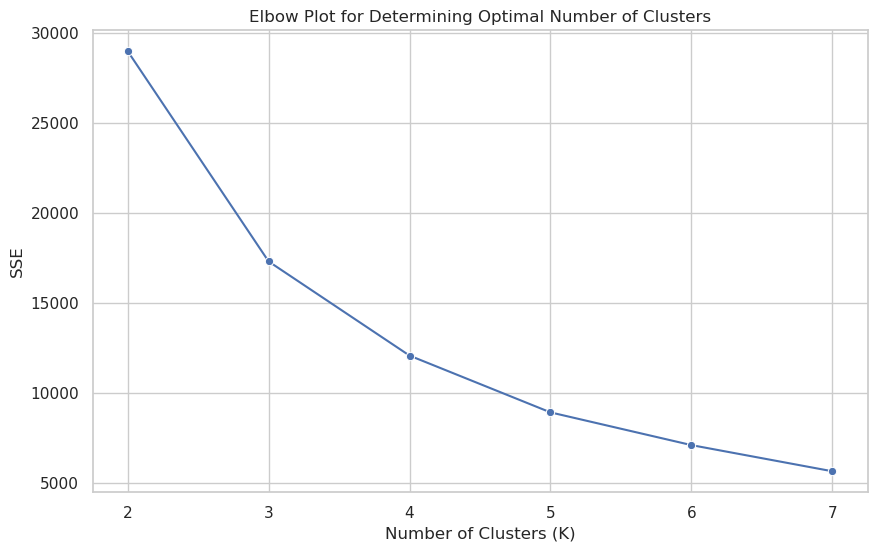

In [16]:
# List to store the Sum of Squared Errors (SSE) for each value of K
sse_values = []

# Print the first few rows of df_pca to verify its content
print(df_pca.head())

# Iterate over each trained model's path to calculate SSE
for k, model_path in model_paths:
    try:
        # Download the model artifacts from S3
        local_path = f'/tmp/model-k-{k}.tar.gz'
        s3_client.download_file(
            sagemaker_session.default_bucket(),
            model_path.replace(f's3://{sagemaker_session.default_bucket()}/', ''),
            local_path
        )
        
        # Extract the model artifacts
        with tarfile.open(local_path) as tar:
            tar.extractall(path=f'/tmp/k-{k}')
        
        # Load the KMeans model parameters
        kmeans_model_params = mx.ndarray.load(f'/tmp/k-{k}/model_algo-1')
        centroids = kmeans_model_params[0].asnumpy()
        
        # Squeeze extra dimensions (e.g. from (K,1,num_features) to (K, num_features))
        centroids = np.squeeze(centroids)
        
        # Calculate distances from each point to each centroid.
        # Convert df_pca to a numpy array to ensure proper broadcasting.
        distances = np.sqrt(((df_pca.values - centroids[:, np.newaxis])**2).sum(axis=2))
        
        # Determine the closest centroid for each data point.
        closest_centroids = np.argmin(distances, axis=0)
        
        # Calculate SSE for this value of K.
        # For each data point, subtract the centroid of its closest cluster.
        sse = np.sum((df_pca.values - centroids[closest_centroids])**2)
        sse_values.append(sse)
    except Exception as e:
        print(f'Error processing model for K={k}: {e}')

# Create and display the Elbow Plot using seaborn and matplotlib.
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x=[k for k, _ in model_paths], y=sse_values, marker='o')
plt.title('Elbow Plot for Determining Optimal Number of Clusters')
plt.xticks([k for k, _ in model_paths])
plt.xlabel("Number of Clusters (K)")
plt.ylabel("SSE")
plt.show()

This “elbow plot” simply shows how well K‑means fits the data as you increase the number of clusters (K). The vertical axis (SSE) measures how “tight” each cluster is — lower is better — and the horizontal axis shows how many clusters you ask for. At first, adding more clusters dramatically reduces the error, but after a certain point (around K = 4 or 5) the improvement slows down and the curve flattens into an “elbow.” That elbow is your sweet spot: it means you’ve captured most of the natural groupings in the data without making the model unnecessarily complicated.

# Silhouette Graph 

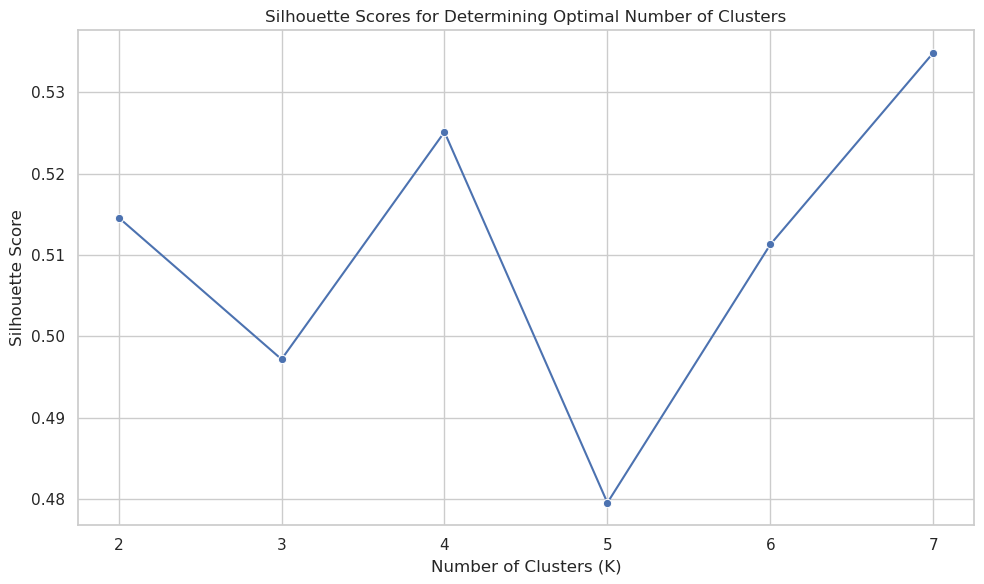

In [17]:
# Ensure silhouette_score is imported
from sklearn.metrics import silhouette_score

# List to store the silhouette scores for each value of K
silhouette_scores = []

# Convert df_pca to a NumPy array (if not already)
data_np = df_pca.values

# Iterate over each trained model's path to calculate its silhouette score
for k, model_path in model_paths:
    try:
        # Download the model artifacts from S3
        local_path = f'/tmp/model-k-{k}.tar.gz'
        s3_client.download_file(
            sagemaker_session.default_bucket(),
            model_path.replace(f's3://{sagemaker_session.default_bucket()}/', ''),
            local_path
        )
        
        # Extract the model artifacts
        with tarfile.open(local_path) as tar:
            tar.extractall(path=f'/tmp/k-{k}')
        
        # Load the KMeans model parameters
        kmeans_model_params = mx.ndarray.load(f'/tmp/k-{k}/model_algo-1')
        centroids = kmeans_model_params[0].asnumpy()
        
        # Squeeze extra dimensions (e.g. from (K,1,num_features) to (K, num_features))
        centroids = np.squeeze(centroids)
        
        # Calculate distances from each point to each centroid
        # centroids[:, np.newaxis] has shape (K,1,num_features), data_np has shape (n, num_features)
        distances = np.sqrt(((data_np - centroids[:, np.newaxis])**2).sum(axis=2))
        
        # Determine the closest centroid for each data point
        closest_centroids = np.argmin(distances, axis=0)
        
        # Calculate the silhouette score for this value of K
        silhouette_score_value = silhouette_score(data_np, closest_centroids)
        silhouette_scores.append(silhouette_score_value)
    except Exception as e:
        print(f'Error processing model for K={k}: {e}')

# Plot the silhouette scores for different values of K, if available
if silhouette_scores:  # Ensure the list is not empty
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=[k for k, _ in model_paths], y=silhouette_scores, marker='o')
    plt.title('Silhouette Scores for Determining Optimal Number of Clusters')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.tight_layout()  # Adjust the layout to make sure everything fits without overlap
    plt.show()
else:
    print("No silhouette scores to plot.")

This plot shows how “cleanly” the data splits into groups for each choice of cluster count (K). The vertical axis (Silhouette Score) measures how similar each point is to its own cluster compared to other clusters — higher scores mean tighter, more distinct groups. You look for the highest score to pick the best K, and here it peaks at 7, meaning seven clusters give you the most well‑separated grouping.

# Creating the Model with the Best Clustering

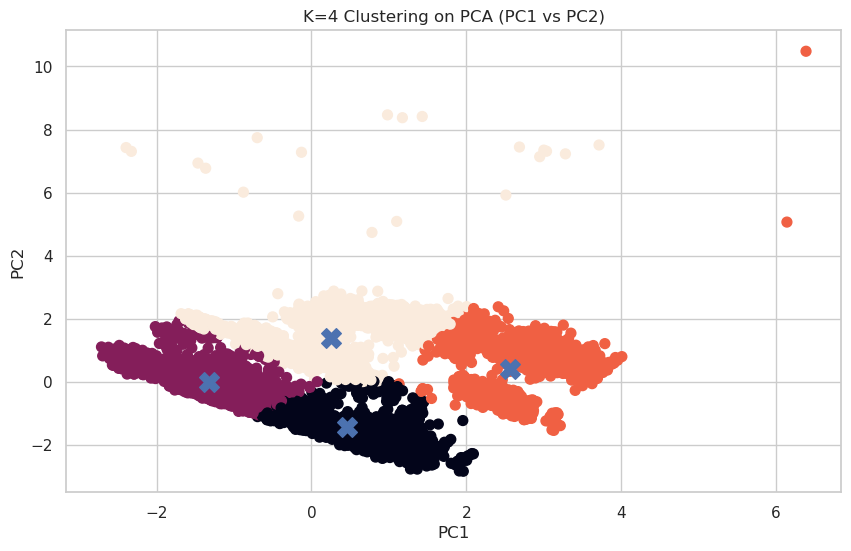

In [18]:
best_k = 4
best_model_path = next(path for k, path in model_paths if k == best_k)
local_path = '/tmp/best_model.tar.gz'

s3_client.download_file(
    sagemaker_session.default_bucket(),
    best_model_path.replace(f's3://{sagemaker_session.default_bucket()}/', ''),
    local_path
)

with tarfile.open(local_path) as tar:
    tar.extractall(path='/tmp/best_model')

# 2️⃣ Load centroids and squeeze extra dims
kmeans_params = mx.ndarray.load('/tmp/best_model/model_algo-1')
centroids_best = np.squeeze(kmeans_params[0].asnumpy())

# 3️⃣ Compute nearest‐centroid labels
data_np = df_pca[['PC1','PC2']].values
distances = np.linalg.norm(data_np[np.newaxis,:,:] - centroids_best[:,None,:], axis=2)
cluster_labels = np.argmin(distances, axis=0)

# 4️⃣ Add cluster labels into your PCA DataFrame
df_pca = df_pca.copy()
df_pca['Cluster'] = cluster_labels

# 5️⃣ Plot clusters + centroids using Matplotlib
plt.figure(figsize=(10,6))
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['Cluster'], s=50)
plt.scatter(centroids_best[:,0], centroids_best[:,1], marker='X', s=200)
plt.title(f'K={best_k} Clustering on PCA (PC1 vs PC2)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

This scatterplot shows all customers mapped onto two simple “summary scores” (PC1 on the x‑axis, PC2 on the y‑axis) and grouped into four distinct clusters. Each colored dot is a single customer, and dots of the same color belong to the same group because they behave similarly in the original data (age, spending, etc.). The large “X” markers are the centers of each group — think of them as the “average” customer for that cluster. In everyday terms, the plot just visually separates your shoppers into four natural segments so you can see which customers share similar habits and which stand out as different.

# Deploying the Model

In [ ]:
# Specify names for the endpoint and its configuration
endpoint_name = 'kmeans'
endpoint_config_name = 'kmeans'

# Function to wait for endpoint configuration deletion
def wait_for_endpoint_config_deletion(endpoint_config_name):
    print(f'Waiting for endpoint configuration "{endpoint_config_name}" to be deleted...')
    while True:
        try:
            sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
            time.sleep(5)  # Poll every 5 seconds
        except ClientError as e:
            if e.response['Error']['Code'] == 'ValidationException':
                print(f'Endpoint configuration "{endpoint_config_name}" deleted.')
                break
            else:
                raise

# Check and delete the existing endpoint configuration if it exists
try:
    sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
    print(f'Endpoint configuration "{endpoint_config_name}" already exists. Deleting...')
    sagemaker_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
    wait_for_endpoint_config_deletion(endpoint_config_name)
except ClientError as e:
    if e.response['Error']['Code'] == 'ValidationException':
        print(f'Endpoint configuration "{endpoint_config_name}" does not exist.')

# Function to wait for endpoint deletion
def wait_for_endpoint_deletion(endpoint_name):
    print(f'Waiting for endpoint "{endpoint_name}" to be deleted...')
    while True:
        try:
            sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
            time.sleep(5)  # Poll every 5 seconds
        except ClientError as e:
            if e.response['Error']['Code'] == 'ValidationException':
                print(f'Endpoint "{endpoint_name}" deleted.')
                break
            else:
                raise

# Check and delete the existing endpoint if it exists
try:
    sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
    print(f'Endpoint "{endpoint_name}" already exists. Deleting...')
    sagemaker_client.delete_endpoint(EndpointName=endpoint_name)
    wait_for_endpoint_deletion(endpoint_name)
except ClientError as e:
    if e.response['Error']['Code'] == 'ValidationException':
        print(f'Endpoint "{endpoint_name}" does not exist.')

# Identify the best model based on prior analysis
best_k = 6  # Assuming best_k is determined through prior analysis
best_model_s3_uri = next(path for k, path in model_paths if k == best_k)

# Create a SageMaker Model object with the best model's artifacts
best_model = Model(
    model_data=best_model_s3_uri,
    image_uri=image_uri,
    role=role,
    sagemaker_session=sagemaker_session
)

# Deploy the model to an endpoint
# Note: This operation can take several minutes to complete.
predictor = best_model.deploy(
    endpoint_name=endpoint_name,
    initial_instance_count=1,
    instance_type='ml.m5.large'
)

print(f'Model deployed to endpoint: {endpoint_name}')

Endpoint configuration "kmeans-V2" does not exist.
Endpoint "kmeans-V2" does not exist.


[03/27/25 14:51:03] INFO     Creating model with name: kmeans-2025-03-27-14-51-03-835               ]8;id=269894;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=532103;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

[03/27/25 14:51:04] INFO     Creating endpoint-config with name kmeans-V2                           ]8;id=35511;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=189521;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py#5937\5937]8;;\

                    INFO     Creating endpoint with name kmeans-V2                                  ]8;id=566771;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=141961;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py#4759\4759]8;;\

-------!Model deployed to endpoint: kmeans-V2


# Create Validation and Training Datasets

In [14]:
# 1️⃣ Load the original full dataset
orig = pd.read_csv('fraudTrain.csv')

# ▶️ “Used” rows: those whose index is in df
df_used = df_untouched.loc[df_untouched.index.isin(df.index)].copy()

# ▶️ Validation = all rows in orig that are NOT in df_used
df_validation = orig.drop(index=df_used.index).reset_index(drop=True)

# Save both DataFrames
df_used.to_csv('fraudTrain_used.csv', index=False)
df_validation.to_csv('fraudTrain_validation.csv', index=False)

print("Rows in df_used:", df_used.shape[0])
print("Rows in df_validation:", df_validation.shape[0])

Rows in df_used: 16887
Rows in df_validation: 1279788


In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1️⃣ Sample 10 random rows from the validation set
# val_samples = df_validation.sample(n=10, random_state=42).copy()
# actuals = val_samples['is_fraud'].values
fraud_val = df_validation[df_validation['is_fraud'] == 1].sample(n=10, random_state=42)
nonfraud_val = df_validation[df_validation['is_fraud'] == 0].sample(n=10, random_state=42)
val_samples = pd.concat([fraud_val, nonfraud_val]).sample(frac=1, random_state=42).copy()

actuals = val_samples['is_fraud'].values

# 2️⃣ Append them to a fresh copy of df_used
df_all = pd.concat([df_used.copy(), val_samples], ignore_index=True)

# 3️⃣ Keep only your eight model inputs
keep = [
    'trans_date_trans_time', 'cc_num', 'merchant', 'category',
    'amt', 'zip', 'trans_num', 'is_fraud'
]
df_all = df_all[keep].copy()

# 4️⃣ Encode categorical features
df_all = encode_categorical_features(df_all)

# 5️⃣ Select numeric columns (exclude the target)
numeric_cols = df_all.select_dtypes(include='number').columns.drop('is_fraud')

# 6️⃣ Impute missing values using median
X_imputed = SimpleImputer(strategy='median').fit_transform(df_all[numeric_cols])

# 7️⃣ Standardize + PCA → 2 components
scaled = StandardScaler().fit_transform(X_imputed)
components = PCA(n_components=2).fit_transform(scaled)

# 8️⃣ Build PCA DataFrame + attach fraud label
df_pca = pd.DataFrame(components, columns=['PC1', 'PC2'])
df_pca['is_fraud'] = df_all['is_fraud'].values

# 9️⃣ Compute distances from training rows (all but last 10) to nearest centroid
train_pca = df_pca.iloc[:-10][['PC1','PC2']].to_numpy()
centroids_2d = centroids_best[:, :2]  # Use the first two dimensions of your centroids

train_distances = np.min(
    np.linalg.norm(train_pca[np.newaxis, :, :] - centroids_2d[:, None, :], axis=2),
    axis=0
)

# 🔟 Set threshold at the 75th percentile
threshold = np.percentile(train_distances, 75)
print(f"Distance threshold (75th percentile): {threshold:.4f}\n")

# 1️⃣1️⃣ Classify the last 10 PCA rows
val_pca = df_pca.iloc[-20:][['PC1','PC2']].to_numpy()
print("Sample | Actual | Distance | Predicted")
for i, vec in enumerate(val_pca):
    dist = np.min(np.linalg.norm(vec - centroids_2d, axis=1))
    pred = 1 if dist > threshold else 0
    print(f"{i+1:>2}     |   {actuals[i]}    |   {dist:.4f}   |     {pred}")


# Deleting the Model

In [ ]:
# Prompt for confirmation before proceeding with the deletion
confirmation = input("Are you sure you want to delete the endpoint and endpoint configuration? (yes/no): ")

if confirmation.lower() == 'yes':

    # Function to delete endpoint configuration
    def delete_endpoint_config(endpoint_config_name):
        try:
            sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
            print(f'Endpoint configuration "{endpoint_config_name}" exists. Deleting...')
            sagemaker_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
            print(f'Endpoint configuration "{endpoint_config_name}" deleted successfully.')
        except ClientError as e:
            if e.response['Error']['Code'] == 'ValidationException':
                print(f'Endpoint configuration "{endpoint_config_name}" does not exist.')
            else:
                raise

    # Function to delete the endpoint
    def delete_endpoint(endpoint_name):
        try:
            sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
            print(f'Endpoint "{endpoint_name}" exists. Deleting...')
            sagemaker_client.delete_endpoint(EndpointName=endpoint_name)
            print(f'Endpoint "{endpoint_name}" deleted successfully.')
        except ClientError as e:
            if e.response['Error']['Code'] == 'ValidationException':
                print(f'Endpoint "{endpoint_name}" does not exist.')
            else:
                raise

    # Delete the endpoint configuration
    delete_endpoint_config(endpoint_config_name)

    # Delete the endpoint
    delete_endpoint(endpoint_name)

else:
    print("Deletion cancelled. The endpoint and its configuration were not deleted.")